# Primary Use Classification

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling1D, BatchNormalization, Conv1D, \
                                    MaxPooling1D, Concatenate, LSTM, Activation, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow_addons.layers import GELU, SpectralNormalization as SN
from tensorflow.keras.metrics import CategoricalAccuracy as Acc, Precision as Pr, Recall as Rc
from tensorflow_addons.metrics import F1Score as F1

In [2]:
%matplotlib inline
file_name = 'classif'
dir_name = file_name + '_dir'
ckpt_dir = dir_name + '/ckpt'
os.mkdir(dir_name)
os.mkdir(ckpt_dir)

In [18]:
data = np.load('../../data/processed/normalized_generated_data.npz')
gen_electrical_data = data['electrical_data']
gen_labels = data['labels']

In [19]:
data = np.load('../../data/processed/full_data.npz')
electrical_data = data['electrical_data'][:500]
labels = data['labels'][:500]

## Split Data

In [20]:
nr_outputs = 5
batch_size = 32

In [21]:
def split_data(data, labels):
    labels = labels[:, 2] - 12
    one_hot = np.zeros((labels.size, nr_outputs))
    one_hot[np.arange(labels.size), labels] = 1
    labels = one_hot
    train_factor, val_factor = 0.8, 0.1
    train_limit, val_limit = int(len(data) * train_factor), int(len(data) * (train_factor + val_factor))
    train_data, train_labels = data[:train_limit], labels[:train_limit]
    val_data, val_labels = data[train_limit:val_limit], labels[train_limit:val_limit]
    test_data, test_labels = data[val_limit:], labels[val_limit:]
    return train_data, train_labels, val_data, val_labels, test_data, test_labels

In [22]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = split_data(electrical_data, labels)
gen_train_data, gen_train_labels, gen_val_data, gen_val_labels, gen_test_data, gen_test_labels = split_data(gen_electrical_data, gen_labels)

## Building the Model

In [23]:
def conv_block(kernel_size, filters, padding, input_layer):
    sn_conv_1d = SN(Conv1D(kernel_size=kernel_size, filters=filters, padding=padding))(input_layer)
    bn = BatchNormalization()(sn_conv_1d)
    act = Activation('relu')(bn)
    mp_1d = MaxPooling1D()(act)
    res = Dropout(0.2)(mp_1d)
    return res

In [24]:
def create_model():
    sampled_data = Input(electrical_data.shape[1:3], name='input_data')
    padding = "valid"
    conv1 = conv_block(4, 16, padding, sampled_data)
    conv2 = conv_block(4, 32, padding, conv1)
    conv3 = conv_block(4, 64, padding, conv2)
    conv4 = conv_block(4, 128, padding, conv3)
    conv5 = conv_block(4, 256, padding, conv4)
    conv6 = conv_block(4, 512, padding, conv5)
    flat = Flatten()(conv6)
    res = SN(Dense(nr_outputs, activation='softmax'))(flat)
    model = Model(sampled_data, res, name="Classifier")
    metrics = [Acc(name='acc'), Pr(name='pr'), Rc(name='rc'), F1(nr_outputs, name='f1')]
    model.compile(optimizer = Adam(1e-3, 0.5, 0.9), loss = 'categorical_crossentropy', metrics=metrics)
    return model

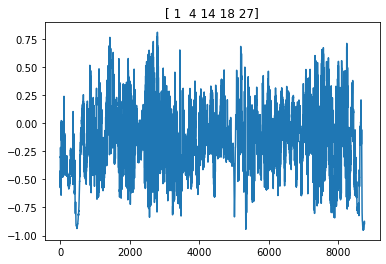

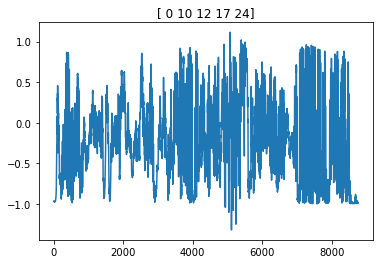

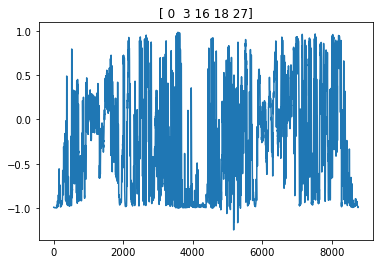

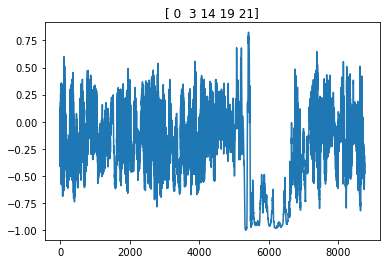

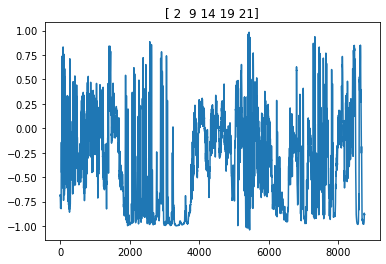

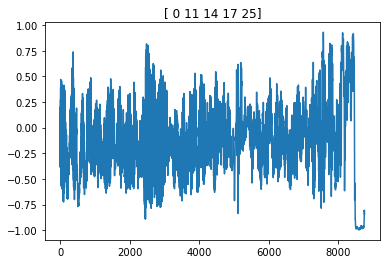

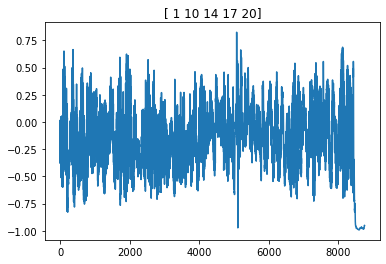

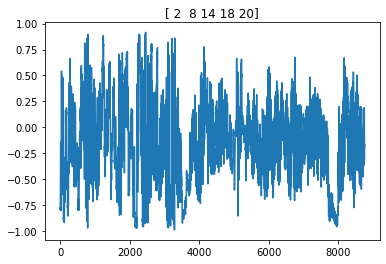

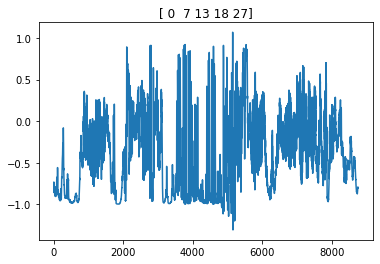

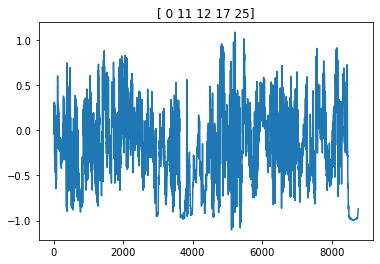

In [25]:
for elec, lb in zip(gen_electrical_data[:10], gen_labels[:10]):
    plt.figure()
    plt.plot(elec[:, 0])
    plt.title(str(lb))

In [21]:
from collections import Counter
strs = [''.join([str(x) for x in lb]) for lb in gen_labels]  
cnt = Counter()
for word in strs:
    cnt[word] += 1
print(cnt)

Counter({'03121923': 8, '29121925': 7, '17151826': 7, '05131721': 7, '06141724': 7, '16131727': 7, '14131726': 6, '16121823': 6, '14151727': 6, '29151723': 6, '211121824': 6, '24131921': 6, '08131826': 6, '210151920': 6, '23141922': 6, '011151927': 6, '210141924': 6, '09121724': 6, '110151826': 6, '24151821': 6, '110161727': 6, '28121825': 6, '24161827': 6, '26161922': 5, '011121722': 5, '110121826': 5, '08151725': 5, '010141924': 5, '011161824': 5, '17131824': 5, '17161820': 5, '27121724': 5, '24151921': 5, '19161724': 5, '011161721': 5, '06131926': 5, '18131927': 5, '17151923': 5, '210141925': 5, '08131722': 5, '29151921': 5, '27141724': 5, '110151824': 5, '19141922': 5, '04161825': 5, '111121726': 5, '26151821': 5, '15131820': 5, '05121922': 5, '15151721': 5, '14121926': 5, '27131724': 5, '28161923': 5, '07131823': 5, '27131921': 5, '28151825': 5, '29121927': 5, '24131922': 5, '25151723': 5, '211141826': 5, '29121926': 5, '03121922': 5, '07151922': 5, '19151720': 5, '17121724': 5, '

In [23]:
cnt[''.join([str(x) for x in labels[7]])]

2

## Trainging the Model

In [26]:
model = create_model()
history = model.fit(train_data, train_labels, batch_size=batch_size, epochs=200, validation_data=(val_data, val_labels))

Epoch 1/200
13/13 [==============================] - 3s 77ms/step - loss: 15.9333 - acc: 0.2521 - pr: 0.2498 - rc: 0.2192 - f1: 0.2211 - val_loss: 1.5254 - val_acc: 0.4600 - val_pr: 0.0000e+00 - val_rc: 0.0000e+00 - val_f1: 0.1260
Epoch 2/200
13/13 [==============================] - 1s 47ms/step - loss: 4.9422 - acc: 0.4788 - pr: 0.4981 - rc: 0.4646 - f1: 0.4430 - val_loss: 1.6075 - val_acc: 0.3000 - val_pr: 0.0000e+00 - val_rc: 0.0000e+00 - val_f1: 0.0923
Epoch 3/200
13/13 [==============================] - 1s 46ms/step - loss: 6.6440 - acc: 0.4339 - pr: 0.4615 - rc: 0.3842 - f1: 0.3618 - val_loss: 1.4910 - val_acc: 0.1800 - val_pr: 0.0000e+00 - val_rc: 0.0000e+00 - val_f1: 0.0610
Epoch 4/200
13/13 [==============================] - 1s 46ms/step - loss: 3.7950 - acc: 0.4745 - pr: 0.4968 - rc: 0.4650 - f1: 0.4259 - val_loss: 1.6984 - val_acc: 0.3000 - val_pr: 0.0000e+00 - val_rc: 0.0000e+00 - val_f1: 0.0923
Epoch 5/200
13/13 [==============================] - 1s 46ms/step - loss: 2.796

Epoch 73/200
13/13 [==============================] - 1s 46ms/step - loss: 0.9821 - acc: 0.7360 - pr: 0.7916 - rc: 0.6883 - f1: 0.6822 - val_loss: 2.7606 - val_acc: 0.3000 - val_pr: 0.3182 - val_rc: 0.2800 - val_f1: 0.1780
Epoch 74/200
13/13 [==============================] - 1s 46ms/step - loss: 0.5235 - acc: 0.8000 - pr: 0.8317 - rc: 0.7727 - f1: 0.7580 - val_loss: 1.7612 - val_acc: 0.3600 - val_pr: 0.2727 - val_rc: 0.0600 - val_f1: 0.1896
Epoch 75/200
13/13 [==============================] - 1s 46ms/step - loss: 0.6122 - acc: 0.7740 - pr: 0.8170 - rc: 0.6981 - f1: 0.7160 - val_loss: 2.8936 - val_acc: 0.1800 - val_pr: 0.1818 - val_rc: 0.1200 - val_f1: 0.1235
Epoch 76/200
13/13 [==============================] - 1s 46ms/step - loss: 0.5475 - acc: 0.7910 - pr: 0.8339 - rc: 0.7669 - f1: 0.7608 - val_loss: 2.1999 - val_acc: 0.2600 - val_pr: 0.2903 - val_rc: 0.1800 - val_f1: 0.2002
Epoch 77/200
13/13 [==============================] - 1s 46ms/step - loss: 0.4486 - acc: 0.8111 - pr: 0.8311

Epoch 110/200
13/13 [==============================] - 1s 46ms/step - loss: 0.3970 - acc: 0.8669 - pr: 0.8855 - rc: 0.8484 - f1: 0.8380 - val_loss: 1.5736 - val_acc: 0.3400 - val_pr: 0.3824 - val_rc: 0.2600 - val_f1: 0.2035
Epoch 111/200
13/13 [==============================] - 1s 46ms/step - loss: 0.3356 - acc: 0.8839 - pr: 0.8949 - rc: 0.8571 - f1: 0.8723 - val_loss: 1.8631 - val_acc: 0.3200 - val_pr: 0.3333 - val_rc: 0.2200 - val_f1: 0.2087
Epoch 112/200
13/13 [==============================] - 1s 46ms/step - loss: 0.4434 - acc: 0.8246 - pr: 0.8383 - rc: 0.7882 - f1: 0.8154 - val_loss: 1.8927 - val_acc: 0.2800 - val_pr: 0.2424 - val_rc: 0.1600 - val_f1: 0.1635
Epoch 113/200
13/13 [==============================] - 1s 46ms/step - loss: 0.4184 - acc: 0.8682 - pr: 0.8929 - rc: 0.8154 - f1: 0.8623 - val_loss: 1.4235 - val_acc: 0.3800 - val_pr: 0.4444 - val_rc: 0.2400 - val_f1: 0.3050
Epoch 114/200
13/13 [==============================] - 1s 46ms/step - loss: 0.4360 - acc: 0.8264 - pr: 0

Epoch 183/200
13/13 [==============================] - 1s 46ms/step - loss: 0.1397 - acc: 0.9515 - pr: 0.9602 - rc: 0.9493 - f1: 0.9483 - val_loss: 2.4387 - val_acc: 0.3000 - val_pr: 0.2683 - val_rc: 0.2200 - val_f1: 0.2338
Epoch 184/200
13/13 [==============================] - 1s 46ms/step - loss: 0.2083 - acc: 0.9188 - pr: 0.9326 - rc: 0.9131 - f1: 0.9135 - val_loss: 2.5430 - val_acc: 0.3600 - val_pr: 0.3617 - val_rc: 0.3400 - val_f1: 0.2729
Epoch 185/200
13/13 [==============================] - 1s 46ms/step - loss: 0.2384 - acc: 0.9256 - pr: 0.9410 - rc: 0.9214 - f1: 0.9067 - val_loss: 2.6942 - val_acc: 0.3200 - val_pr: 0.3333 - val_rc: 0.2400 - val_f1: 0.2331
Epoch 186/200
13/13 [==============================] - 1s 47ms/step - loss: 0.3478 - acc: 0.8831 - pr: 0.9068 - rc: 0.8587 - f1: 0.8795 - val_loss: 3.1696 - val_acc: 0.3800 - val_pr: 0.3778 - val_rc: 0.3400 - val_f1: 0.2608
Epoch 187/200
13/13 [==============================] - 1s 47ms/step - loss: 0.2610 - acc: 0.8962 - pr: 0

In [43]:
early_stopping_monitor = EarlyStopping(patience=3)
gen_model = create_model()
gen_history = gen_model.fit(gen_train_data, gen_train_labels, batch_size=batch_size, epochs=100, validation_data=(gen_val_data, \
                        gen_val_labels), callbacks=[early_stopping_monitor])

Epoch 1/100
125/125 [==============================] - 8s 51ms/step - loss: 3.0099 - acc: 0.7328 - pr: 0.7411 - rc: 0.7271 - f1: 0.7347 - val_loss: 19.5869 - val_acc: 0.2040 - val_pr: 0.2040 - val_rc: 0.2040 - val_f1: 0.0678
Epoch 2/100
125/125 [==============================] - 6s 45ms/step - loss: 0.8184 - acc: 0.9026 - pr: 0.9034 - rc: 0.9017 - f1: 0.9039 - val_loss: 12.3757 - val_acc: 0.2040 - val_pr: 0.2040 - val_rc: 0.2040 - val_f1: 0.0678
Epoch 3/100
125/125 [==============================] - 6s 45ms/step - loss: 0.5095 - acc: 0.9268 - pr: 0.9274 - rc: 0.9266 - f1: 0.9269 - val_loss: 0.4092 - val_acc: 0.8760 - val_pr: 0.8773 - val_rc: 0.8720 - val_f1: 0.8852
Epoch 4/100
125/125 [==============================] - 6s 45ms/step - loss: 0.5298 - acc: 0.9304 - pr: 0.9310 - rc: 0.9289 - f1: 0.9306 - val_loss: 2.5688 - val_acc: 0.6120 - val_pr: 0.6137 - val_rc: 0.6100 - val_f1: 0.5932
Epoch 5/100
125/125 [==============================] - 6s 45ms/step - loss: 0.3481 - acc: 0.9419 - pr:

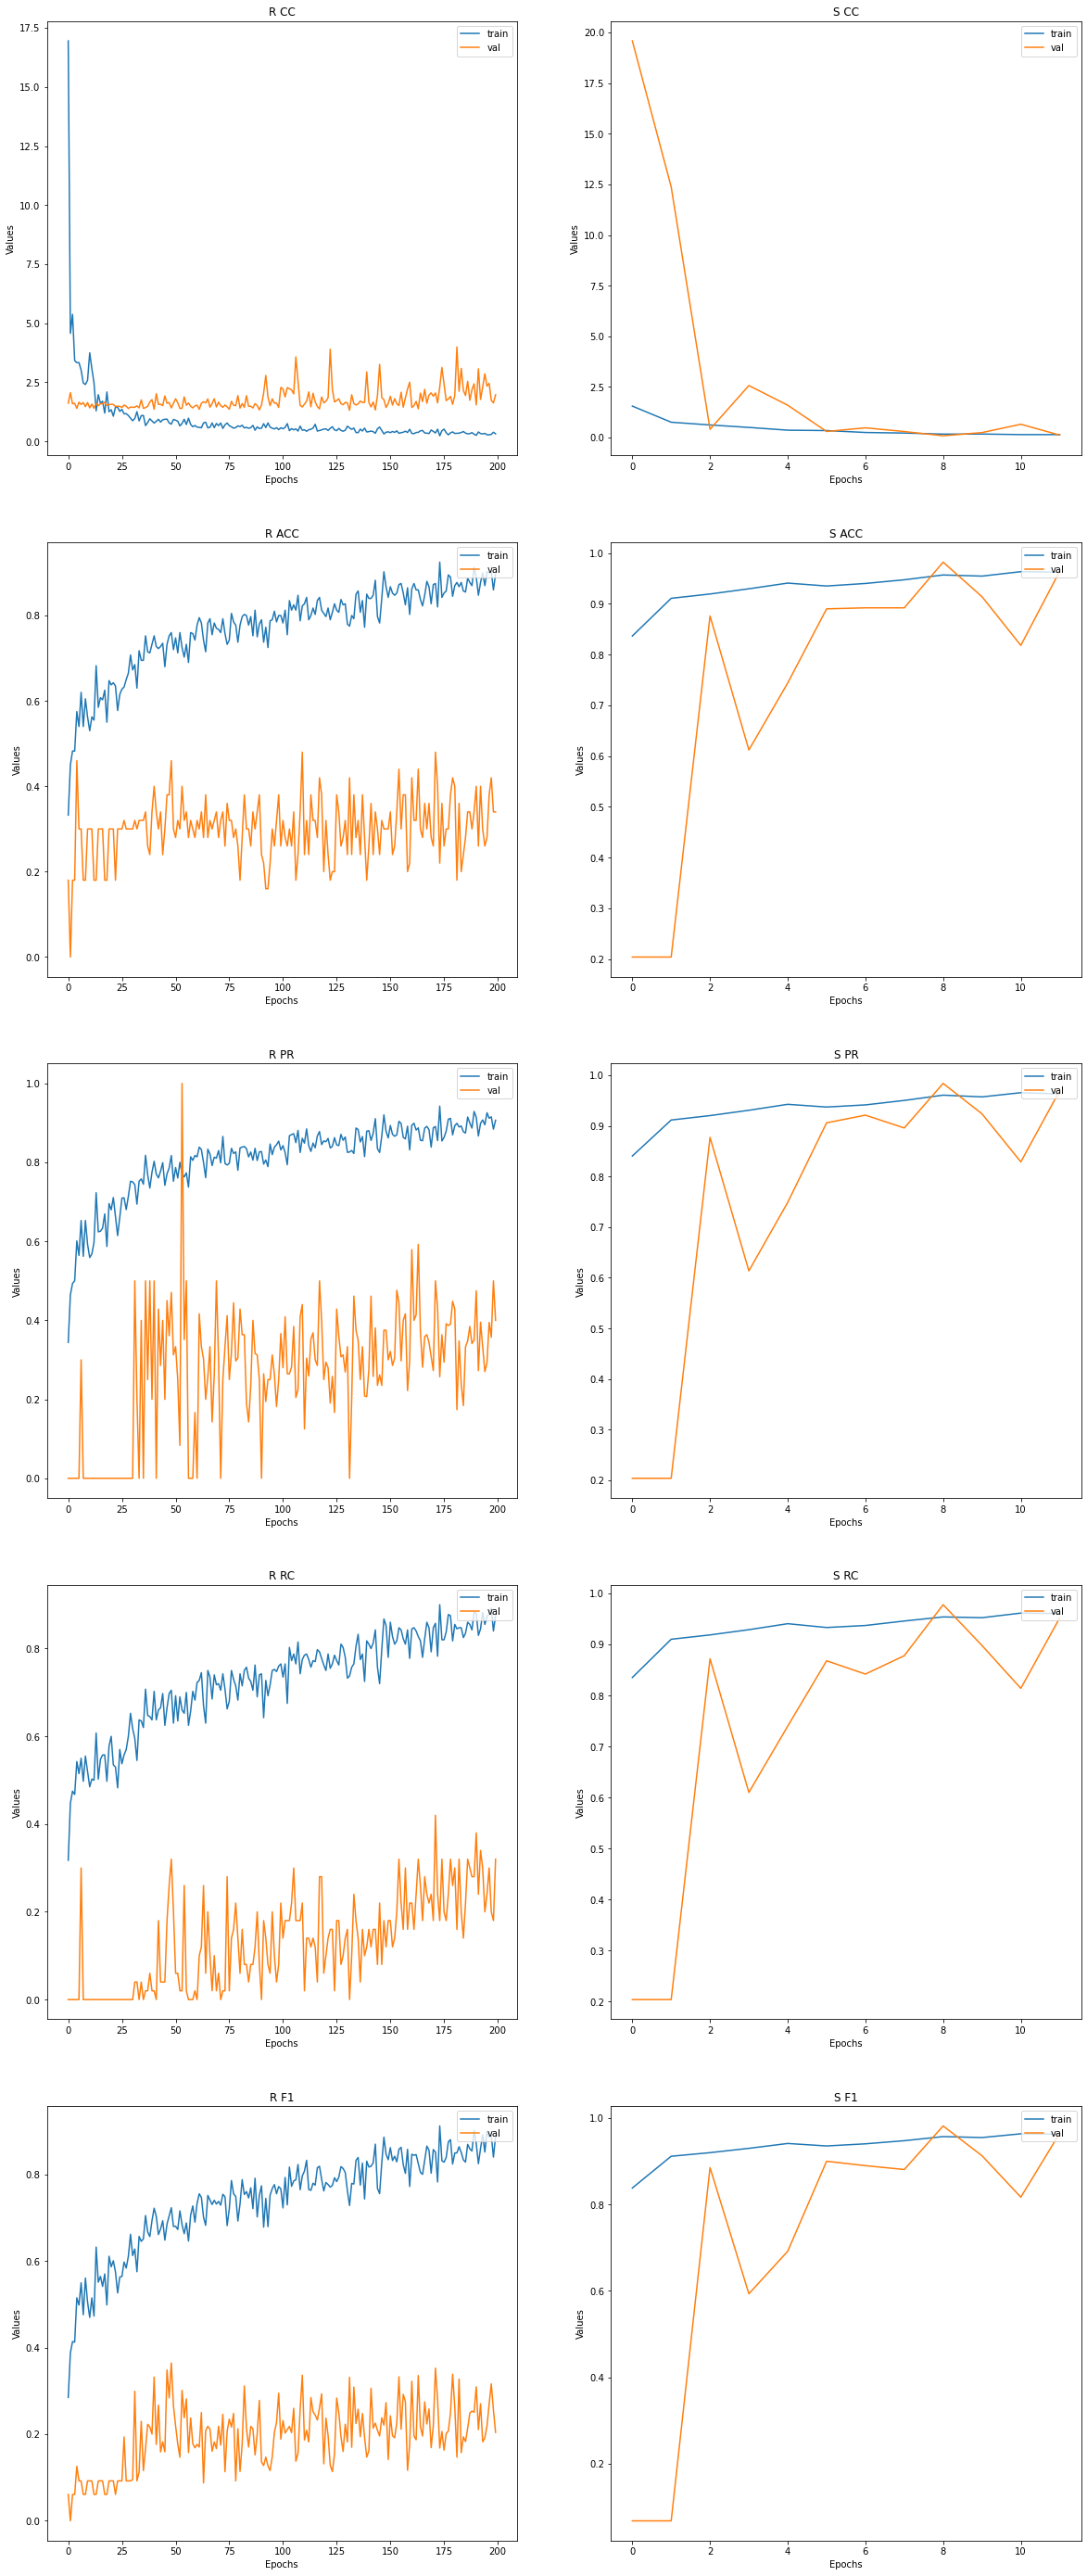

In [44]:
fig, axs = plt.subplots(5, 2)
fig.set_size_inches(20, 50)
for i, his in enumerate([history, gen_history]):
    h = his.history
    data_type = 'R ' if i == 0 else 'S '
    for j, metric in enumerate(['loss', 'acc', 'pr', 'rc', 'f1']):
        title = metric if metric != 'loss' else 'CC'
        ax = axs[j, i]
        ax.plot(h[metric], label='train')
        ax.plot(h['val_' + metric], label='val')
        ax.title.set_text(data_type + title.upper())
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Values')
        ax.legend(loc="upper right")

In [45]:
model.save_weights(ckpt_dir + '/weights.ckpt')
gen_model.save_weights(ckpt_dir + '/gen_weights.ckpt')

## Test the Model

### TRTR

In [27]:
model_eval = model.evaluate(test_data, test_labels, batch_size=batch_size)

2/2 [==============================] - 0s 13ms/step - loss: 3.2938 - acc: 0.1800 - pr: 0.2195 - rc: 0.1800 - f1: 0.2223


### TRTS

In [47]:
model_eval_on_gen = model.evaluate(gen_test_data, gen_test_labels, batch_size=batch_size)

16/16 [==============================] - 0s 15ms/step - loss: 3.8327 - acc: 0.3520 - pr: 0.3641 - rc: 0.3160 - f1: 0.2983


### TSTR

In [48]:
gen_model_eval = gen_model.evaluate(test_data, test_labels, batch_size=batch_size)

2/2 [==============================] - 0s 13ms/step - loss: 1.8090 - acc: 0.5600 - pr: 0.6176 - rc: 0.4200 - f1: 0.1534


### TSTS

In [49]:
gen_model_eval_on_gen = gen_model.evaluate(gen_test_data, gen_test_labels, batch_size=batch_size)

16/16 [==============================] - 0s 15ms/step - loss: 0.1106 - acc: 0.9620 - pr: 0.9776 - rc: 0.9580 - f1: 0.9605


In [50]:
metrics = history.history
gen_metrics = {'gen_' + key: val for key, val in gen_history.history.items()}
np.savez_compressed(dir_name + '_metrics&evals.npz', **metrics, **gen_metrics, trtr=model_eval, trts=model_eval_on_gen, \
                    tstr=gen_model_eval, tsts=gen_model_eval_on_gen)

In [3]:
metrics = np.load('classification_metrics&evals.npz')

In [6]:
for k in metrics.keys():
    print(k)
f1, val_f1, gen_f1, val_gen_f1

loss
acc
pr
rc
f1
val_loss
val_acc
val_pr
val_rc
val_f1
gen_loss
gen_acc
gen_pr
gen_rc
gen_f1
gen_val_loss
gen_val_acc
gen_val_pr
gen_val_rc
gen_val_f1
trtr
trts
tstr
tsts


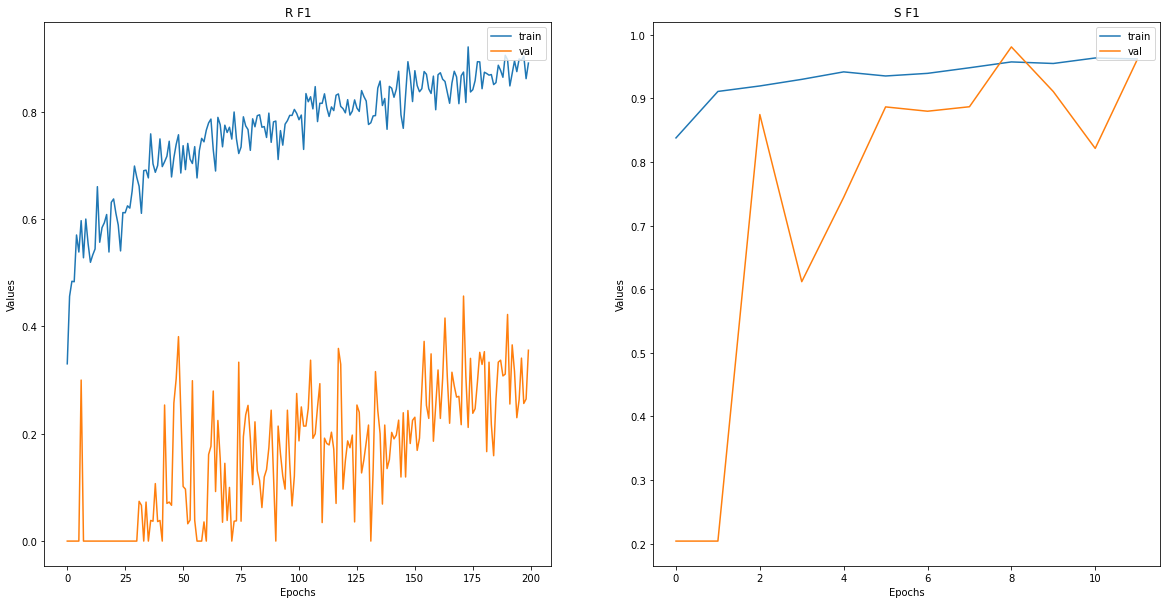

In [12]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 10)
for i, data_type in enumerate(['R', 'S']):
    pref = '' if i == 0 else 'gen_'
    values = 2 * metrics[pref + 'pr'] * metrics[pref + 'rc'] / (metrics[pref + 'pr'] + metrics[pref + 'rc'] + 1e-7)
    val_values = 2 * metrics[pref + 'val_pr'] * metrics[pref + 'val_rc'] / (metrics[pref + 'val_pr'] + metrics[pref + 'val_rc'] + 1e-7)
    ax = axs[i]
    ax.plot(values, label='train')
    ax.plot(val_values, label='val')
    ax.title.set_text(data_type + ' F1')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Values')
    ax.legend(loc="upper right")

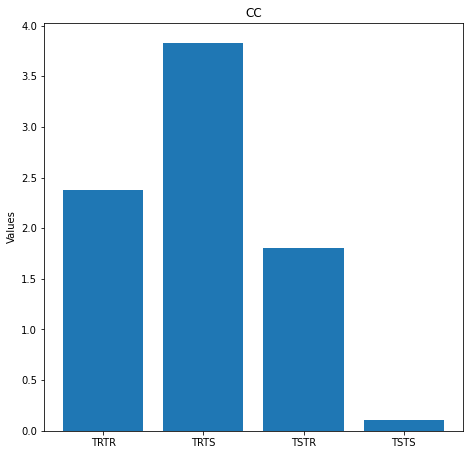

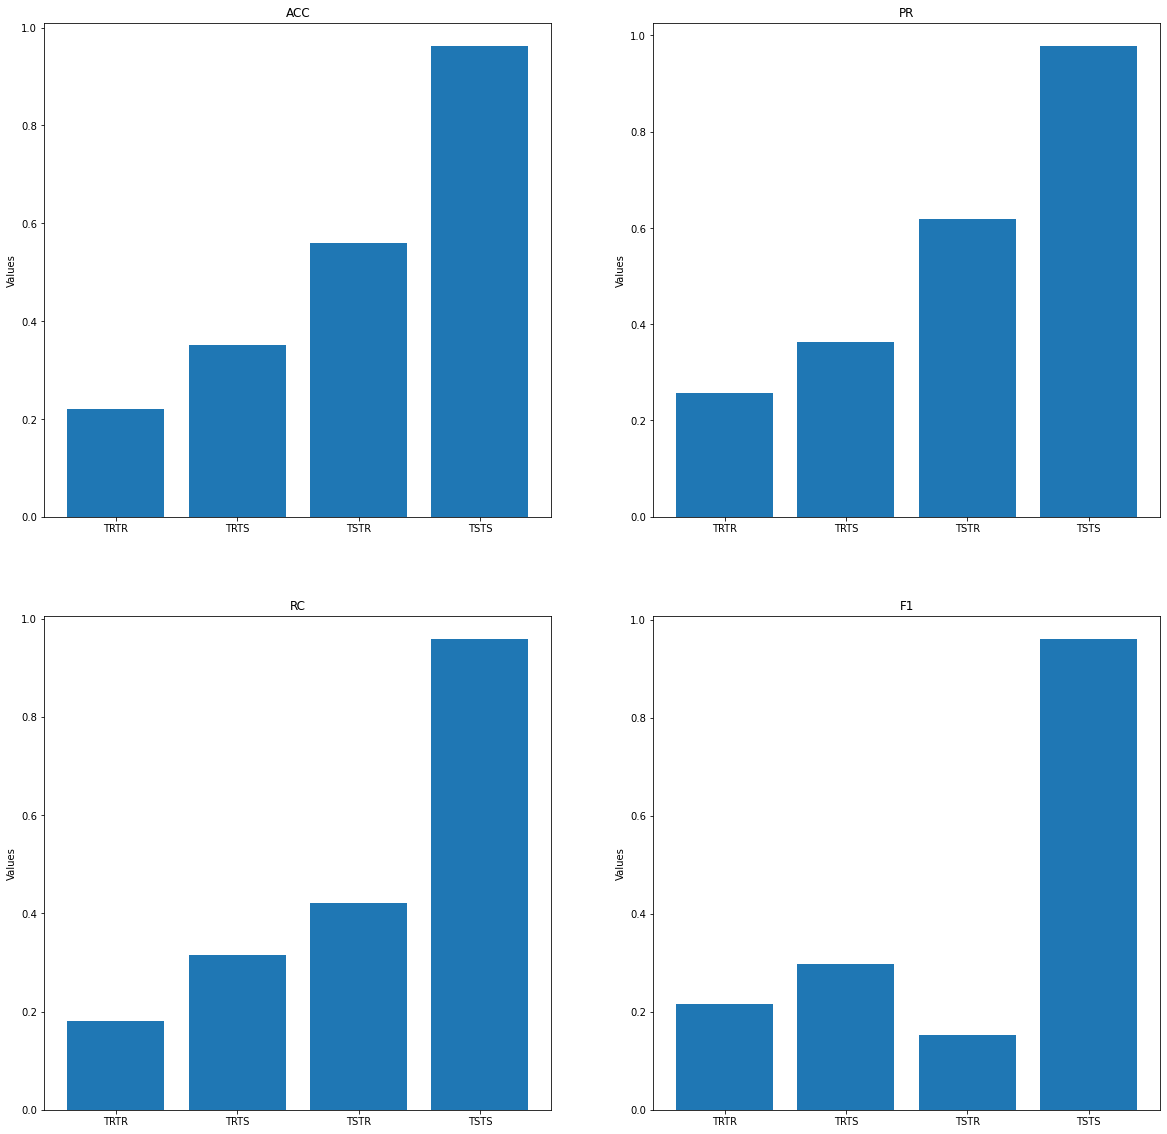

In [51]:
fig = plt.figure()
fig.set_size_inches(7.5, 7.5)
plt.bar(['TRTR', 'TRTS', 'TSTR', 'TSTS'], [model_eval[0], model_eval_on_gen[0], gen_model_eval[0], gen_model_eval_on_gen[0]])
plt.title('CC')
plt.ylabel('Values')
plt.show()

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(20, 20)
for i, metric in enumerate(['acc', 'pr', 'rc', 'f1'], 1):
    ax = axs[(i - 1) // 2, (i - 1) % 2]
    ax.bar(['TRTR', 'TRTS', 'TSTR', 'TSTS'], [model_eval[i], model_eval_on_gen[i], gen_model_eval[i], gen_model_eval_on_gen[i]])
    ax.title.set_text(metric.upper())
    ax.set_ylabel('Values')

Text(0, 0.5, 'Values')

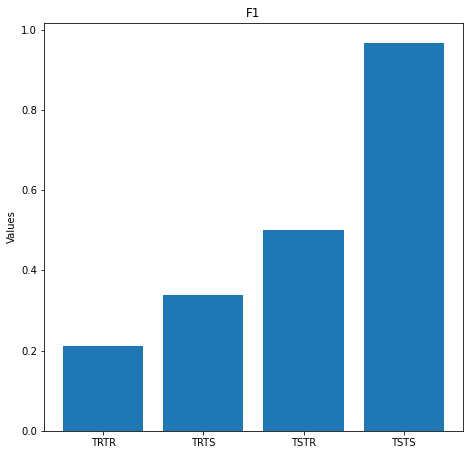

In [23]:
# Correct F1
PR, RC = 2, 3
values = []
for mtrs in [metrics['trtr'], metrics['trts'], metrics['tstr'], metrics['tsts']]:
    values.append(2 * mtrs[PR] * mtrs[RC] / (mtrs[PR] + mtrs[RC]))
fig = plt.figure()
fig.set_size_inches(7.5, 7.5)
plt.bar(['TRTR', 'TRTS', 'TSTR', 'TSTS'], values)
plt.title('F1')
plt.ylabel('Values')